In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import pysm3
import pysm3.units as u
from mapsim.noise_calc import *
import os

### Create a simple single frequency CMB map with pysm3

In [2]:
idir = 'input_maps/'
ddir = f'{idir}data/'

In [3]:
import os
os.environ['PYSM_LOCAL_DATA']=f'/pscratch/sd/s/susannaz/BBFLP/'

In [4]:
# Define params
nside = 64 #512
nu = 90
unit = u.uK_CMB
np.random.seed(1000)

In [5]:
lmax = 3*nside-1
ells = np.arange(lmax)
dl2cl = np.ones(len(ells))
dl2cl[1:] = 2*np.pi/(ells[1:]*(ells[1:]+1.))

In [6]:
# CMB C_ells
# Lensing
l,dtt,dee,dbb,dte=np.loadtxt(f"{ddir}camb_lens_nobb.dat",unpack=True)
l = l.astype(int)
msk = l <= lmax - 1
l = l[msk]
dltt=np.zeros(len(ells)); dltt[l]=dtt[msk]
dlee=np.zeros(len(ells)); dlee[l]=dee[msk]
dlbb=np.zeros(len(ells)); dlbb[l]=dbb[msk]
dlte=np.zeros(len(ells)); dlte[l]=dte[msk]  
cl_cmb_tt_lens=dltt * dl2cl
cl_cmb_bb_lens=dlbb * dl2cl
cl_cmb_ee_lens=dlee * dl2cl

In [7]:
# Lensing + r=1
l,dtt,dee,dbb,dte=np.loadtxt(f"{ddir}camb_lens_r1.dat",unpack=True)
l = l.astype(int)
msk = l <= lmax - 1
l = l[msk]
dltt=np.zeros(len(ells)); dltt[l]=dtt[msk]
dlee=np.zeros(len(ells)); dlee[l]=dee[msk]
dlbb=np.zeros(len(ells)); dlbb[l]=dbb[msk]
dlte=np.zeros(len(ells)); dlte[l]=dte[msk]  
cl_cmb_tt_r1=dltt * dl2cl
cl_cmb_ee_r1=dlbb * dl2cl
cl_cmb_bb_r1=dlee * dl2cl

In [8]:
# Full CMB
input_r = 0.01
cl_cmb_tt = cl_cmb_tt_lens + input_r * (cl_cmb_tt_r1 - cl_cmb_tt_lens)
cl_cmb_ee = cl_cmb_ee_lens + input_r * (cl_cmb_ee_r1 - cl_cmb_ee_lens)
cl_cmb_bb = cl_cmb_bb_lens + input_r * (cl_cmb_bb_r1 - cl_cmb_bb_lens)
cl0 = 0 * cl_cmb_bb

In [9]:
# CMB amplitude
IQU_maps = hp.synfast([cl_cmb_tt, cl_cmb_ee, cl_cmb_bb, cl0, cl0, cl0],
                                nside, new=True)

In [10]:
IQU_maps .shape

(3, 49152)

In [17]:
# Write to disk
hp.write_map(f"{idir}CMB_IQUampmaps_ns{nside}.fits", IQU_maps, dtype=['float64','float64','float64'], overwrite=True)

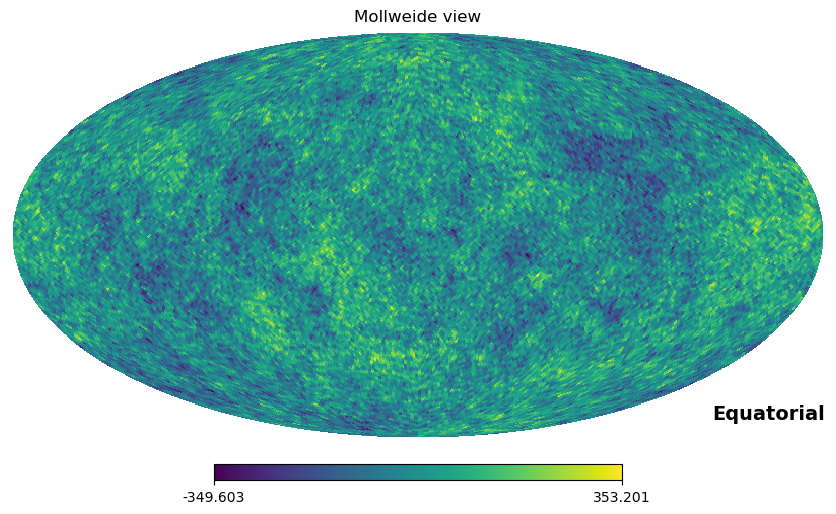

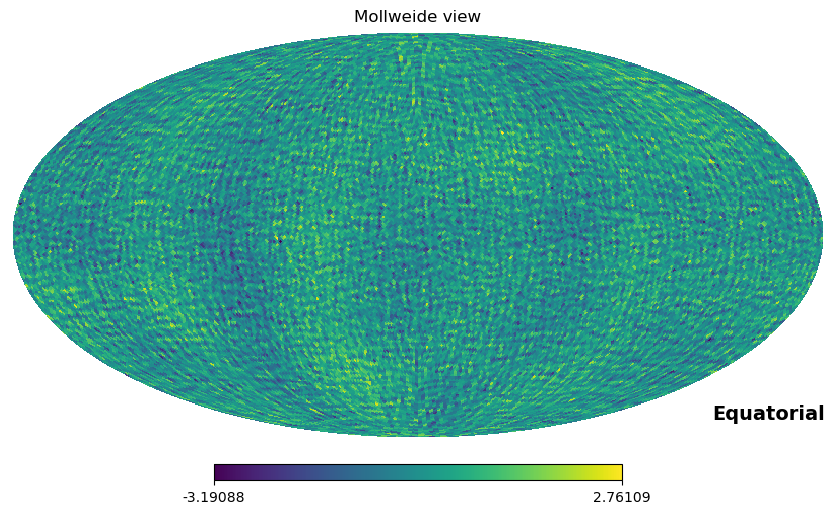

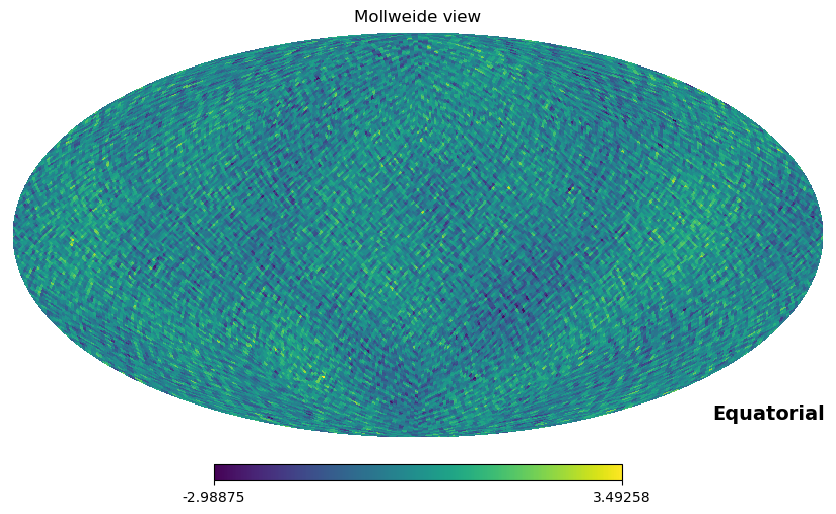

In [11]:
for npol in np.arange(3):
    hp.mollview(IQU_maps[npol], coord='C')

In [19]:
# Generate sky map
#cmps = ["c1"] # sky components, currently CMB only
#sky = pysm3.Sky(nside=nside, component_objects=[pysm3.CMBMap(nside, map_IQU=f'{nmc_str}/{file_name}')])
sky = pysm3.Sky(nside=nside, component_objects=[pysm3.CMBMap(nside, map_IQU=f"{idir}CMB_IQUampmaps_ns{nside}.fits")])
mapp = sky.get_emission(nu * u.GHz)
mapp.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(nu*u.GHz))

<Quantity [[-2.73428058e+00, -5.51111341e+00, -3.37467960e+01, ...,
            -6.65591233e+01, -1.54348984e+02, -4.66065508e+01],
           [ 1.14913559e-01, -2.31365024e-01,  1.46654631e+00, ...,
            -1.03386956e+00, -5.29706281e-01,  1.44714697e-01],
           [ 3.14748773e-01,  4.12784774e-01, -3.30143937e-01, ...,
             1.07040876e-02, -7.45777045e-01, -1.25081376e+00]] uK_CMB>

In [20]:
# Smoothing, Equatorial coordinates, RING format
smooth = 1
if smooth:
    lmax = 3*nside-1
    beams = Simons_Observatory_V3_SA_beam_FWHM()
    ch_name = 'SO_SAT_93'
    nch = 2 #2nd freq channel
    fwhm = beams[nch]/60 #rad
    #map = pysm3.apply_smoothing_and_coord_transform(mapp, fwhm=fwhm, lmax=lmax, rot=hp.Rotator(coord="GC"))
    map = hp.smoothing(mapp, fwhm = np.radians(fwhm/60.))
else:
    map = mapp

In [21]:
# Write to disk 
os.system('mkdir -p input_maps')
hp.write_map(f'input_maps/cmb_SAT_f0{nu}_ns{nside}.fits', map, coord="C", dtype=np.float32, overwrite=True)

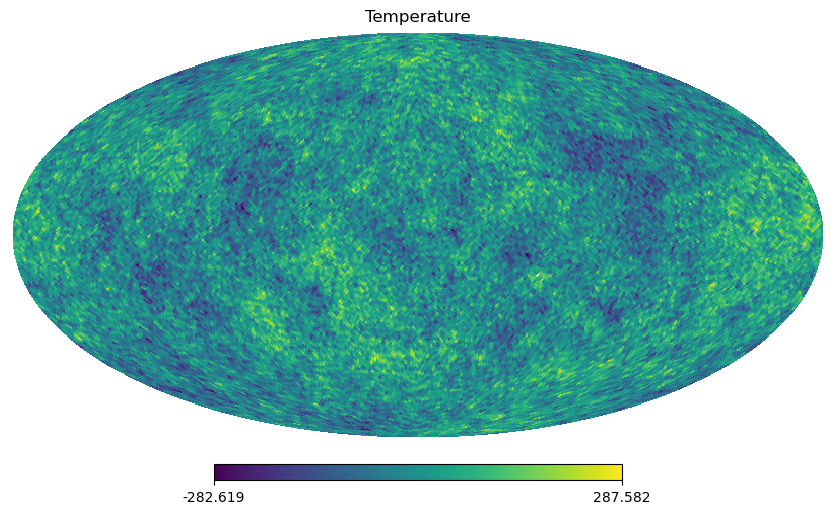

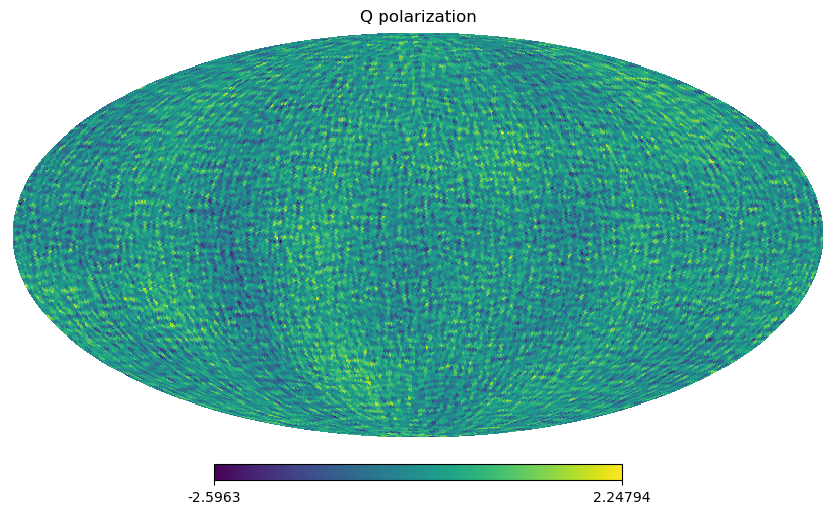

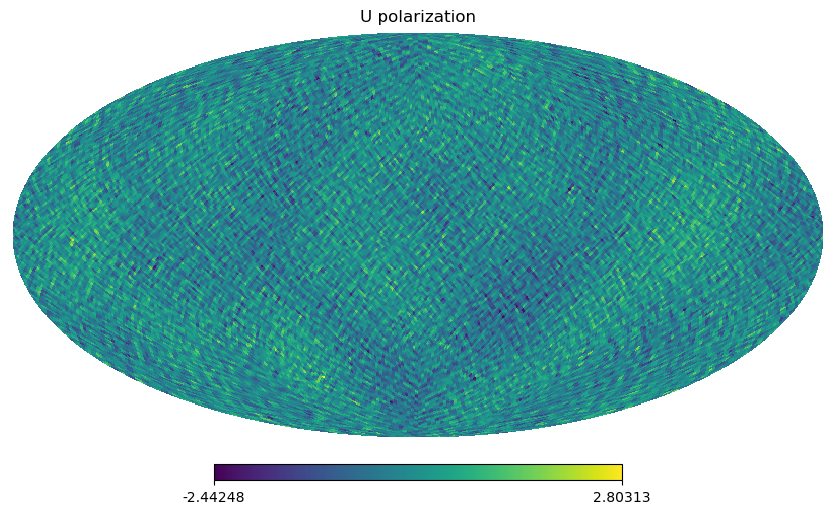

In [22]:
# Plot
npol = 3 
lbl = ['Temperature', 'Q polarization', 'U polarization']
for pol in np.arange(npol):
    hp.mollview(map[pol,:], title=lbl[pol])

In [9]:
#TODO: Integrate with current tools, e.g. BBSims

#### Continue to the next section

Go to [Section 3 - Schedule](Sec3_Make_and_Analyze_schedule.ipynb).